In [24]:
# CS194-26 (CS294-26): Project 1 starter Python code
# these are just some suggested libraries
import numpy as np
import skimage as sk
import skimage.io as skio
from skimage import img_as_ubyte
# name of the input file
imname = 'icon.tif'
#imname = 'cathedral.jpg'

In [25]:
# read in the image
im = skio.imread(imname)
# convert to double (might want to do this later on to save memory)    
im = sk.img_as_float(im)   
# compute the height of each part (just 1/3 of total)
height = np.floor(im.shape[0] / 3.0).astype(np.int)

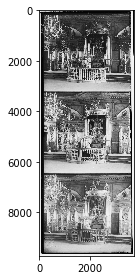

In [26]:
skio.imshow(im)

In [27]:
# separate color channels
b = im[:height]
g = im[height: 2*height]
r = im[2*height: 3*height]

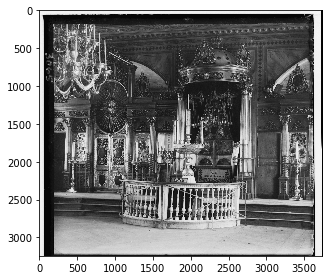

In [28]:
skio.imshow(b)

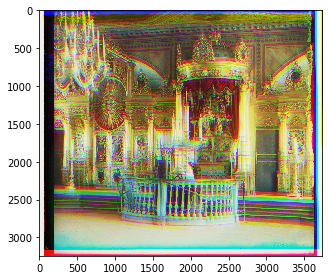

In [29]:
# create a color image
im_out = np.dstack([r, g, b])
im_out = img_as_ubyte(im_out) # 将float64转化为uint8格式
# save the image
fname = '../out_fname-dp.jpg'
skio.imsave(fname, im_out)
# display the image
skio.imshow(im_out)
skio.show()

In [30]:
import numpy as np
import skimage as sk
import skimage.io as skio
import skimage.transform
import skimage.filters
from skimage import feature,data,color

# name of the input file
imname = 'emir.tif'
#imname = 'cathedral.jpg'

# read in the image
im = skio.imread(imname)

print("dimension: ", im.shape)
# convert to double (might want to do this later on to save memory)    
im = sk.img_as_float(im)

# compute the height of each part (just 1/3 of total)
height = im.shape[0] // 3
width = im.shape[1]
print("height: ", height)
# separate color channels
b = im[:height]
g = im[height: 2*height]
r = im[2*height: 3*height]

canny = feature.canny(g) * 1
diff = np.linalg.norm(canny - np.roll(canny, 1, axis=0), axis=0) / height
print(canny[:10,:10])
print(diff[450:460])
print(np.mean(canny, axis=0)[450:460])

dimension:  (9627, 3702)
height:  3209
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
[0.00268069 0.00295632 0.00298899 0.00282187 0.00295632 0.00311624
 0.00326834 0.00335629 0.00335629 0.00314724]
[0.07634777 0.09005921 0.12184481 0.07416641 0.08756622 0.09411031
 0.11218448 0.11311935 0.11000312 0.08538486]


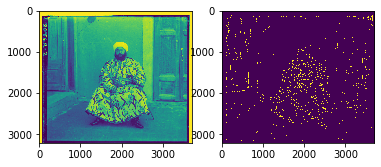

array([0., 0., 0., ..., 0., 0., 0.])

In [31]:
skio.imshow_collection([b, feature.canny(b)])
skio.show()
diff

In [32]:
def SSD(im1, im2):
	try:
		return -np.linalg.norm(np.abs(np.gradient(im1)[0]) - np.abs(np.gradient(im2)[0])) - np.linalg.norm(np.abs(np.gradient(im1)[1]) - np.abs(np.gradient(im2)[1]))
	except ValueError:
		return -np.linalg.norm(im1 - im2)

def NCC(im1, im2, eps=1e-7):
	try:
		grad1, grad2 = np.gradient(im1), np.gradient(im2)
		l = grad1[0].size
		grad1x, grad2x = grad1[0].reshape((l, )), grad2[0].reshape((l, ))
		grad1y, grad2y = grad1[1].reshape((l, )), grad2[1].reshape((l, ))

		grad1x, grad2x = grad1x / (np.linalg.norm(grad1x) + eps), grad2x / (np.linalg.norm(grad2x) + eps)
		grad1y, grad2y = grad1y / (np.linalg.norm(grad1y) + eps), grad2y / (np.linalg.norm(grad2y) + eps)
		return np.abs(grad1x).dot(np.abs(grad2x)) + np.abs(grad1y).dot(np.abs(grad2y))
	except ValueError:
		im1, im2 = im1.reshape((im1.size, )), im2.reshape((im2.size, ))
		im1_normalized, im2_normalized = im1 / np.linalg.norm(im1), im2 / np.linalg.norm(im2)
		return im1_normalized.dot(im2_normalized)

    
def NCC2(arr1, arr2):
	arr1 = arr1.reshape((arr1.size, ))
	arr2 = arr2.reshape((arr2.size, ))
	return arr1.dot(arr2)

def pyramid_find_displacement(im, fixed, n, e, matching_metric=NCC):
	if n == 0:
		return find_displacement(im, fixed)
	im_resized = sk.transform.rescale(sk.filters.gaussian(im), .5)
	fixed_resized = sk.transform.rescale(sk.filters.gaussian(fixed), .5)
	displacement_vector = pyramid_find_displacement(im_resized, fixed_resized, n - 1, e * 2) * 2
	print("displacement vector: ", displacement_vector)
	print("shape: ", im.shape)
	return find_neighboring_displacement(im, fixed, displacement_vector, e, matching_metric)

def find_neighboring_displacement(im, fixed, displacement_vector, e, matching_metric=NCC):
	copy = np.copy(im)
	best_displacement_x = displacement_vector[0]
	best_displacement_y = displacement_vector[1]
	best_matching_score = float("-inf")
	h, w = im.shape
	x_lower_bound = max(best_displacement_x - e, -h//10 + 1)
	x_upper_bound = min(best_displacement_x + e, h//10 - 1) + 1
	y_lower_bound = max(best_displacement_y - e, -w//10 + 1)
	y_upper_bound = min(best_displacement_y + e, w//10 - 1) + 1
	for i in range(x_lower_bound, x_upper_bound):
		for j in range(y_lower_bound, y_upper_bound):
			im = np.roll(np.roll(copy, j, axis=1), i, axis=0)
			score = matching_metric(fixed, im)
			if score > best_matching_score:
				best_displacement_x, best_displacement_y, best_matching_score = i, j, score
			# print("\ti:{}, j, {}, x: [{}, {}], {}; y: [{},  {}], {}, score: {}, best score: {}".format(i, j, x_lower_bound, x_upper_bound, best_displacement_x, y_lower_bound, y_upper_bound, best_displacement_y, score, best_matching_score))

	return np.array([best_displacement_x, best_displacement_y])


def find_displacement(im, fixed, matching_metric=NCC):
	copy = np.copy(im)
	best_displacement_x = 0
	best_displacement_y = 0
	best_matching_score = float("-inf")
	h, w = im.shape
	for i in range(-h + 1, h):
		for j in range(-w + 1, w):
			im = np.roll(np.roll(copy, j, axis=1), i, axis=0)
			score = matching_metric(fixed, im)
			if score > best_matching_score:
				# print("\t{}, {}, score: {}".format(i, j, score))
				best_displacement_x, best_displacement_y, best_matching_score = i, j, score
	return np.array([best_displacement_x, best_displacement_y])

def pyramid_align(im, fixed, matching_metric=NCC):
	# skio.imshow_collection(np.gradient(im))
	# print(np.mean(np.gradient(im)[0]))
	# skio.show()
	n = int(np.floor(np.log2(np.min(im.shape))))
	displacement_x, displacement_y = pyramid_find_displacement(im, fixed, n, 1, matching_metric)
	print(displacement_x, displacement_y)
	return np.roll(np.roll(im, displacement_y, axis=1), displacement_x, axis=0)

def crop(r, g, b):
	for i in range(4):
		r, g, b = crop_one_side(r, g, b)
		r, g, b = np.rot90(r), np.rot90(g), np.rot90(b)
	return r, g, b

# def crop_one_side(r, g, b):
# 	# r_gradient, g_gradient, b_gradient = get_blockwise_gradient(r), get_blockwise_gradient(g), get_blockwise_gradient(b)
# 	# r_gradient, g_gradient, b_gradient = np.gradient(r)[0], np.gradient(g)[0], np.gradient(b)[0]
# 	# r_gradient, g_gradient, b_gradient = difference_of_gaussians(r), difference_of_gaussians(g), difference_of_gaussians(b)
# 	r_gradient, g_gradient, b_gradient = r, g, b
# 	# print(r_gradient[:50,50])
# 	# print(np.mean(r_gradient[:,50]))
# 	# print(np.max(np.abs(b_gradient[:,5])))
# 	row_to_crop = max(find_row_to_crop(r_gradient), find_row_to_crop(g_gradient), find_row_to_crop(b_gradient))
# 	print("row to crop: ", row_to_crop)
# 	r_cropped, g_cropped, b_cropped = r[:,row_to_crop:], g[:,row_to_crop:], b[:,row_to_crop:]
# 	row_to_crop = max(find_row_to_crop_black(r_cropped), find_row_to_crop_black(g_cropped), find_row_to_crop_black(b_cropped))
# 	print("row to crop: ", row_to_crop)
# 	r_cropped, g_cropped, b_cropped = r_cropped[:,row_to_crop:], g_cropped[:,row_to_crop:], b_cropped[:,row_to_crop:]
# 	return r_cropped, g_cropped, b_cropped
# def find_row_to_crop(im, thresh=.90):
# 	start = 0
# 	h, w = im.shape
# 	end = w
# 	m = 8 #(start + end) // 2
# 	blocksize = 8
# 	# while (m < w and np.mean(np.abs(im[:,m])) < thresh):
# 	while (m < w // 10):
# 		if np.mean(np.abs(im[:,m:m+blocksize])) < thresh:
# 			if blocksize == 1:
# 				break
# 			else:
# 				blocksize -= 1
# 		else:
# 			m += blocksize
# 		# print(np.mean(np.abs(im[:,m:m+blocksize])))
# 	return m

def crop_one_side(r, g, b):
	r_gradient, g_gradient, b_gradient = r, g, b

	row_to_crop = max(find_row_to_crop(r_gradient), find_row_to_crop(g_gradient), find_row_to_crop(b_gradient))
	print("row to crop: ", row_to_crop)
	r_cropped, g_cropped, b_cropped = r[:,row_to_crop:], g[:,row_to_crop:], b[:,row_to_crop:]

	return r_cropped, g_cropped, b_cropped

def find_row_to_crop(im, thresh=.90):
	m = 0
	_, w = im.shape
	end = w // 10
	canny = feature.canny(im) * 2 - 1
	h, _ = canny.shape
	left_width = 4
	line_width = 2
	right_width = 1
	mask_width = left_width + line_width + right_width
	mean = np.mean(canny, axis=1)
	mask = np.concatenate((-1 * np.ones((h, left_width)), np.ones((h, line_width)), -1 * np.ones((h, right_width))), axis=1)
	# mask = np.concatenate((-1 * np.ones((h, left_width)), np.ones((h, line_width)), -1 * np.ones((h, right_width))), axis=1)
	border = 0
	best_score = float("-inf")
	print(np.sum(canny[:, line_width + right_width]))
	print(canny.shape, im.shape)

	# print(canny[:20,:20])
	print(best_score)
	scores = []
	while (m < end):
		score = NCC2(mask, canny[:, m: m + mask_width])
		scores.append(score)
		if (score > best_score):
			best_score = score
			border = m + left_width
		print("best score: ", best_score, border, "score: ", score, m)
		m += 1
	scores = np.asarray(scores)
	std = np.std(scores)
	mean = np.mean(scores)
	print("sd: ", std, "mean: ", mean)
	local_maxima_indices = np.where(scores >= mean + std)[0]
	print("local maxima:", local_maxima_indices)
	if len(local_maxima_indices) > 0 and np.max(local_maxima_indices) + left_width > border:
		border = np.max(local_maxima_indices) + left_width
	# skio.imshow_collection([(canny + 1) / 2, (canny[:,border:] + 1) / 2])
	# skio.show()
	return border

# def find_row_to_crop(im, thresh=.90):
# 	m = 0
# 	h, w = im.shape
# 	end = w // 5
# 	canny = feature.canny(b) * 1
# 	diff = np.linalg.norm(canny - np.roll(canny, 1, axis=0), axis=0) / h
# 	mean = np.mean(canny, axis=0)
# 	border_found = False
# 	border = m
# 	while m < end:
# 		while m < end:
# 			if mean[m] > .06 and diff[m] < .002:
# 				border_found = True
# 				border = m
# 				break
# 			else:
# 				m += 1
# 		if border_found:
# 			border_found = False
# 		else:
# 			break
# 		m += 1
# 	return border

def find_row_to_crop_black(im, thresh=.2):
	start = 0
	h, w = im.shape
	end = w
	m = 0 #(start + end) // 2
	blocksize = 8
	while (m < w // 10):
		if np.mean(np.abs(im[:,m:m+8])) > thresh:
			if blocksize == 1:
				break
			else:
				blocksize -= 1
		else:
			m += blocksize
		print(m, np.mean(np.abs(im[:,m:m+blocksize])))
		m += blocksize
	return m


def difference_of_gaussians(im, num_differences=5):
	sigmas = np.linspace(0, 2, 2 * num_differences)
	difference = np.zeros(im.shape)
	for i in range(num_differences):
		sigma1 = sigmas[2*i]
		sigma2 = sigmas[2*i+1]
		difference += sk.filters.gaussian(im, sigma=sigma1) - sk.filters.gaussian(im, sigma=sigma2)
	return difference / num_differences * 100

def get_luminance(r, g, b):
	return  0.2126 * r + 0.7152 * g + 0.0722 * b

def get_brightest_pixel(channel):
	brightest_index = np.argmax(channel)
	h, w = channel.shape
	x, y = brightest_index // h, brightest_index % w
	return x, y

def get_darkest_pixel(channel):
	darkest_index = np.argmin(channel)
	h, w = channel.shape
	x, y = darkest_index // h, darkest_index % w
	return x, y

def auto_contrast(r, g, b):
	luminance = get_luminance(r, g, b)
	brightest_x, brightest_y = get_brightest_pixel(luminance)
	darkest_x, darkest_y = get_darkest_pixel(luminance)
	brightest_channel_index = np.argmax([r[brightest_x, brightest_y], 
										 g[brightest_x, brightest_y],
										 b[brightest_x, brightest_y]])
	print(brightest_channel_index)
	brightest_channel = [r, g, b][brightest_channel_index]
	darkest_channel_index = np.argmin([r[darkest_x, darkest_y], 
									g[darkest_x, darkest_y],
									b[darkest_x, darkest_y]])
	print(darkest_channel_index)
	darkest_channel = [r, g, b][darkest_channel_index]
	darkest_channel = normalize_brightness(darkest_channel)
	result = [r, g, b]
	result[brightest_channel_index] = normalize_brightness(brightest_channel)
	result[darkest_channel_index] = normalize_brightness(darkest_channel)
	return result

def normalize_brightness(channel):
	brightest_value = np.max(channel)
	darkest_value = np.min(channel)
	scale = brightest_value - darkest_value
	return (channel - darkest_value) / scale
# align the images
# functions that might be useful for aligning the images include:
# np.roll, np.sum, sk.transform.rescale (for multiscale)
# ag = g
# ar = r

-3209
(3209, 3702) (3209, 3702)
-inf
best score:  9627.0 4 score:  9627.0 0
best score:  9627.0 4 score:  9627.0 1
best score:  9627.0 4 score:  9627.0 2
best score:  9627.0 4 score:  9627.0 3
best score:  9627.0 4 score:  9627.0 4
best score:  9627.0 4 score:  9627.0 5
best score:  9627.0 4 score:  9627.0 6
best score:  9627.0 4 score:  9627.0 7
best score:  9627.0 4 score:  9627.0 8
best score:  9627.0 4 score:  9627.0 9
best score:  9627.0 4 score:  9627.0 10
best score:  9627.0 4 score:  9627.0 11
best score:  9627.0 4 score:  9627.0 12
best score:  9627.0 4 score:  9627.0 13
best score:  9627.0 4 score:  9627.0 14
best score:  9627.0 4 score:  9627.0 15
best score:  9627.0 4 score:  9627.0 16
best score:  9627.0 4 score:  9627.0 17
best score:  9627.0 4 score:  9627.0 18
best score:  9627.0 4 score:  9627.0 19
best score:  9627.0 4 score:  9627.0 20
best score:  9627.0 4 score:  9627.0 21
best score:  9627.0 4 score:  9627.0 22
best score:  9627.0 4 score:  9627.0 23
best score:  

best score:  12685.0 83 score:  9087.0 285
best score:  12685.0 83 score:  9133.0 286
best score:  12685.0 83 score:  9033.0 287
best score:  12685.0 83 score:  9007.0 288
best score:  12685.0 83 score:  9045.0 289
best score:  12685.0 83 score:  9041.0 290
best score:  12685.0 83 score:  9071.0 291
best score:  12685.0 83 score:  9031.0 292
best score:  12685.0 83 score:  8981.0 293
best score:  12685.0 83 score:  9031.0 294
best score:  12685.0 83 score:  9099.0 295
best score:  12685.0 83 score:  9137.0 296
best score:  12685.0 83 score:  9123.0 297
best score:  12685.0 83 score:  9115.0 298
best score:  12685.0 83 score:  9107.0 299
best score:  12685.0 83 score:  9223.0 300
best score:  12685.0 83 score:  9295.0 301
best score:  12685.0 83 score:  9253.0 302
best score:  12685.0 83 score:  9247.0 303
best score:  12685.0 83 score:  9223.0 304
best score:  12685.0 83 score:  9225.0 305
best score:  12685.0 83 score:  9257.0 306
best score:  12685.0 83 score:  9227.0 307
best score:

best score:  14749.0 82 score:  8387.0 280
best score:  14749.0 82 score:  8517.0 281
best score:  14749.0 82 score:  8817.0 282
best score:  14749.0 82 score:  8691.0 283
best score:  14749.0 82 score:  8629.0 284
best score:  14749.0 82 score:  8501.0 285
best score:  14749.0 82 score:  8381.0 286
best score:  14749.0 82 score:  8553.0 287
best score:  14749.0 82 score:  8773.0 288
best score:  14749.0 82 score:  8923.0 289
best score:  14749.0 82 score:  8925.0 290
best score:  14749.0 82 score:  8871.0 291
best score:  14749.0 82 score:  8917.0 292
best score:  14749.0 82 score:  8967.0 293
best score:  14749.0 82 score:  8997.0 294
best score:  14749.0 82 score:  9007.0 295
best score:  14749.0 82 score:  8985.0 296
best score:  14749.0 82 score:  8995.0 297
best score:  14749.0 82 score:  8981.0 298
best score:  14749.0 82 score:  9023.0 299
best score:  14749.0 82 score:  8989.0 300
best score:  14749.0 82 score:  9011.0 301
best score:  14749.0 82 score:  9007.0 302
best score:

best score:  13005.0 80 score:  9403.0 267
best score:  13005.0 80 score:  9379.0 268
best score:  13005.0 80 score:  9393.0 269
best score:  13005.0 80 score:  9357.0 270
best score:  13005.0 80 score:  9335.0 271
best score:  13005.0 80 score:  9357.0 272
best score:  13005.0 80 score:  9423.0 273
best score:  13005.0 80 score:  9471.0 274
best score:  13005.0 80 score:  9351.0 275
best score:  13005.0 80 score:  9231.0 276
best score:  13005.0 80 score:  9263.0 277
best score:  13005.0 80 score:  9343.0 278
best score:  13005.0 80 score:  9261.0 279
best score:  13005.0 80 score:  9267.0 280
best score:  13005.0 80 score:  9253.0 281
best score:  13005.0 80 score:  9127.0 282
best score:  13005.0 80 score:  9229.0 283
best score:  13005.0 80 score:  9363.0 284
best score:  13005.0 80 score:  9215.0 285
best score:  13005.0 80 score:  9241.0 286
best score:  13005.0 80 score:  9321.0 287
best score:  13005.0 80 score:  9269.0 288
best score:  13005.0 80 score:  9243.0 289
best score:

best score:  10465.0 94 score:  10281.0 279
best score:  10465.0 94 score:  10287.0 280
best score:  10465.0 94 score:  10275.0 281
best score:  10465.0 94 score:  10243.0 282
best score:  10465.0 94 score:  10301.0 283
best score:  10465.0 94 score:  10321.0 284
best score:  10465.0 94 score:  10311.0 285
best score:  10465.0 94 score:  10337.0 286
best score:  10465.0 94 score:  10301.0 287
best score:  10465.0 94 score:  10289.0 288
best score:  10465.0 94 score:  10311.0 289
best score:  10465.0 94 score:  10319.0 290
best score:  10465.0 94 score:  10335.0 291
best score:  10465.0 94 score:  10347.0 292
best score:  10465.0 94 score:  10353.0 293
best score:  10465.0 94 score:  10343.0 294
best score:  10465.0 94 score:  10361.0 295
best score:  10465.0 94 score:  10379.0 296
best score:  10465.0 94 score:  10355.0 297
best score:  10465.0 94 score:  10335.0 298
best score:  10465.0 94 score:  10327.0 299
best score:  10465.0 94 score:  10305.0 300
best score:  10465.0 94 score:  

best score:  10367.0 152 score:  9913.0 275
best score:  10367.0 152 score:  9843.0 276
best score:  10367.0 152 score:  9829.0 277
best score:  10367.0 152 score:  9793.0 278
best score:  10367.0 152 score:  9803.0 279
best score:  10367.0 152 score:  9889.0 280
best score:  10367.0 152 score:  9893.0 281
best score:  10367.0 152 score:  9943.0 282
best score:  10367.0 152 score:  9907.0 283
best score:  10367.0 152 score:  9857.0 284
best score:  10367.0 152 score:  9837.0 285
best score:  10367.0 152 score:  9845.0 286
best score:  10367.0 152 score:  9905.0 287
best score:  10367.0 152 score:  9861.0 288
best score:  10367.0 152 score:  9841.0 289
best score:  10367.0 152 score:  9863.0 290
best score:  10367.0 152 score:  9831.0 291
best score:  10367.0 152 score:  9837.0 292
best score:  10367.0 152 score:  9861.0 293
best score:  10367.0 152 score:  9909.0 294
best score:  10367.0 152 score:  9915.0 295
best score:  10367.0 152 score:  9905.0 296
best score:  10367.0 152 score: 

best score:  10751.0 98 score:  10183.0 284
best score:  10751.0 98 score:  10207.0 285
best score:  10751.0 98 score:  10217.0 286
best score:  10751.0 98 score:  10299.0 287
best score:  10751.0 98 score:  10243.0 288
best score:  10751.0 98 score:  10155.0 289
best score:  10751.0 98 score:  10145.0 290
best score:  10751.0 98 score:  10159.0 291
best score:  10751.0 98 score:  10211.0 292
best score:  10751.0 98 score:  10243.0 293
best score:  10751.0 98 score:  10229.0 294
best score:  10751.0 98 score:  10245.0 295
best score:  10751.0 98 score:  10241.0 296
best score:  10751.0 98 score:  10247.0 297
best score:  10751.0 98 score:  10297.0 298
best score:  10751.0 98 score:  10251.0 299
best score:  10751.0 98 score:  10205.0 300
best score:  10751.0 98 score:  10245.0 301
best score:  10751.0 98 score:  10251.0 302
best score:  10751.0 98 score:  10249.0 303
best score:  10751.0 98 score:  10305.0 304
best score:  10751.0 98 score:  10281.0 305
best score:  10751.0 98 score:  

best score:  10347.0 80 score:  8589.0 268
best score:  10347.0 80 score:  8797.0 269
best score:  10347.0 80 score:  8737.0 270
best score:  10347.0 80 score:  8519.0 271
best score:  10347.0 80 score:  8377.0 272
best score:  10347.0 80 score:  8377.0 273
best score:  10347.0 80 score:  8327.0 274
best score:  10347.0 80 score:  8525.0 275
best score:  10347.0 80 score:  8525.0 276
best score:  10347.0 80 score:  8485.0 277
best score:  10347.0 80 score:  8483.0 278
best score:  10347.0 80 score:  8469.0 279
best score:  10347.0 80 score:  8431.0 280
best score:  10347.0 80 score:  8459.0 281
best score:  10347.0 80 score:  8589.0 282
best score:  10347.0 80 score:  8611.0 283
best score:  10347.0 80 score:  8511.0 284
best score:  10347.0 80 score:  8507.0 285
best score:  10347.0 80 score:  8469.0 286
best score:  10347.0 80 score:  8483.0 287
best score:  10347.0 80 score:  8579.0 288
best score:  10347.0 80 score:  8635.0 289
best score:  10347.0 80 score:  8805.0 290
best score:

best score:  11453.0 70 score:  7765.0 264
best score:  11453.0 70 score:  7811.0 265
best score:  11453.0 70 score:  7791.0 266
best score:  11453.0 70 score:  7819.0 267
best score:  11453.0 70 score:  7697.0 268
best score:  11453.0 70 score:  7871.0 269
best score:  11453.0 70 score:  8309.0 270
best score:  11453.0 70 score:  8293.0 271
best score:  11453.0 70 score:  7939.0 272
best score:  11453.0 70 score:  7835.0 273
best score:  11453.0 70 score:  7767.0 274
best score:  11453.0 70 score:  7787.0 275
best score:  11453.0 70 score:  8029.0 276
best score:  11453.0 70 score:  8073.0 277
best score:  11453.0 70 score:  8053.0 278
best score:  11453.0 70 score:  8157.0 279
best score:  11453.0 70 score:  8045.0 280
best score:  11453.0 70 score:  7921.0 281
best score:  11453.0 70 score:  7963.0 282
best score:  11453.0 70 score:  8125.0 283
best score:  11453.0 70 score:  8163.0 284
best score:  11453.0 70 score:  8325.0 285
best score:  11453.0 70 score:  8433.0 286
best score:

best score:  9783.0 60 score:  8419.0 286
best score:  9783.0 60 score:  8061.0 287
best score:  9783.0 60 score:  7889.0 288
best score:  9783.0 60 score:  8107.0 289
best score:  9783.0 60 score:  8125.0 290
best score:  9783.0 60 score:  8289.0 291
best score:  9783.0 60 score:  8203.0 292
best score:  9783.0 60 score:  8215.0 293
best score:  9783.0 60 score:  8353.0 294
best score:  9783.0 60 score:  8267.0 295
best score:  9783.0 60 score:  8093.0 296
best score:  9783.0 60 score:  8329.0 297
best score:  9783.0 60 score:  8677.0 298
best score:  9783.0 60 score:  8489.0 299
best score:  9783.0 60 score:  8095.0 300
best score:  9783.0 60 score:  7985.0 301
best score:  9783.0 60 score:  8061.0 302
best score:  9783.0 60 score:  8099.0 303
best score:  9783.0 60 score:  8199.0 304
best score:  9783.0 60 score:  8217.0 305
best score:  9783.0 60 score:  8121.0 306
best score:  9783.0 60 score:  8099.0 307
best score:  9783.0 60 score:  8403.0 308
best score:  9783.0 60 score:  857

best score:  10687.0 216 score:  9205.0 274
best score:  10687.0 216 score:  9281.0 275
best score:  10687.0 216 score:  9161.0 276
best score:  10687.0 216 score:  9259.0 277
best score:  10687.0 216 score:  9407.0 278
best score:  10687.0 216 score:  9223.0 279
best score:  10687.0 216 score:  9253.0 280
best score:  10687.0 216 score:  9391.0 281
best score:  10687.0 216 score:  9365.0 282
best score:  10687.0 216 score:  9277.0 283
best score:  10687.0 216 score:  9381.0 284
best score:  10687.0 216 score:  9391.0 285
best score:  10687.0 216 score:  9403.0 286
best score:  10687.0 216 score:  9475.0 287
best score:  10687.0 216 score:  9439.0 288
best score:  10687.0 216 score:  9427.0 289
best score:  10687.0 216 score:  9539.0 290
best score:  10687.0 216 score:  9501.0 291
best score:  10687.0 216 score:  9547.0 292
best score:  10687.0 216 score:  9611.0 293
best score:  10687.0 216 score:  9531.0 294
best score:  10687.0 216 score:  9423.0 295
best score:  10687.0 216 score: 

best score:  10127.0 46 score:  9795.0 280
best score:  10127.0 46 score:  9761.0 281
best score:  10127.0 46 score:  9703.0 282
best score:  10127.0 46 score:  9709.0 283
best score:  10127.0 46 score:  9809.0 284
best score:  10127.0 46 score:  9865.0 285
best score:  10127.0 46 score:  9851.0 286
best score:  10127.0 46 score:  9879.0 287
best score:  10127.0 46 score:  9859.0 288
best score:  10127.0 46 score:  9835.0 289
best score:  10127.0 46 score:  9905.0 290
best score:  10127.0 46 score:  9917.0 291
best score:  10127.0 46 score:  9841.0 292
best score:  10127.0 46 score:  9833.0 293
best score:  10127.0 46 score:  9853.0 294
best score:  10127.0 46 score:  9817.0 295
best score:  10127.0 46 score:  9815.0 296
best score:  10127.0 46 score:  9889.0 297
best score:  10127.0 46 score:  9893.0 298
best score:  10127.0 46 score:  9763.0 299
best score:  10127.0 46 score:  9691.0 300
best score:  10127.0 46 score:  9731.0 301
best score:  10127.0 46 score:  9707.0 302
best score:

best score:  10221.0 37 score:  9801.0 280
best score:  10221.0 37 score:  9813.0 281
best score:  10221.0 37 score:  9881.0 282
best score:  10221.0 37 score:  9923.0 283
best score:  10221.0 37 score:  9893.0 284
best score:  10221.0 37 score:  9887.0 285
best score:  10221.0 37 score:  9923.0 286
best score:  10221.0 37 score:  9857.0 287
best score:  10221.0 37 score:  9897.0 288
best score:  10221.0 37 score:  9951.0 289
best score:  10221.0 37 score:  9939.0 290
best score:  10221.0 37 score:  9991.0 291
best score:  10221.0 37 score:  9935.0 292
best score:  10221.0 37 score:  9863.0 293
best score:  10221.0 37 score:  9965.0 294
best score:  10221.0 37 score:  9919.0 295
best score:  10221.0 37 score:  9845.0 296
best score:  10221.0 37 score:  9903.0 297
best score:  10221.0 37 score:  9887.0 298
best score:  10221.0 37 score:  9937.0 299
best score:  10221.0 37 score:  10007.0 300
best score:  10221.0 37 score:  9993.0 301
best score:  10221.0 37 score:  9953.0 302
best score

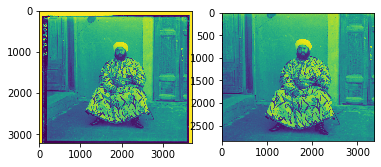

In [33]:
r_cropped, g_cropped, b_cropped = crop(r, g, b)

skio.imshow_collection([b, b_cropped])
skio.show()

displacement vector:  [0 0]
shape:  (3, 3)
displacement vector:  [0 0]
shape:  (6, 6)
displacement vector:  [0 0]
shape:  (11, 13)
displacement vector:  [-2  0]
shape:  (22, 26)
displacement vector:  [0 2]
shape:  (44, 53)
displacement vector:  [4 2]
shape:  (89, 106)
displacement vector:  [6 2]
shape:  (178, 211)
displacement vector:  [14  4]
shape:  (355, 422)
displacement vector:  [26 10]
shape:  (710, 843)
displacement vector:  [54 20]
shape:  (1420, 1686)
displacement vector:  [106  40]
shape:  (2840, 3373)
107 40
displacement vector:  [0 0]
shape:  (3, 3)
displacement vector:  [0 0]
shape:  (6, 6)
displacement vector:  [0 0]
shape:  (11, 13)
displacement vector:  [0 0]
shape:  (22, 26)
displacement vector:  [0 0]
shape:  (44, 53)
displacement vector:  [0 0]
shape:  (89, 106)
displacement vector:  [4 2]
shape:  (178, 211)
displacement vector:  [6 2]
shape:  (355, 422)
displacement vector:  [12  6]
shape:  (710, 843)
displacement vector:  [24 12]
shape:  (1420, 1686)
displacement v

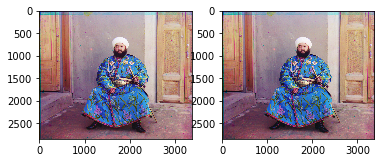

In [34]:
ar = pyramid_align(r_cropped, b_cropped)
ag = pyramid_align(g_cropped, b_cropped)
# create a color image
im_stacked = np.dstack([r, g, b])
im_out = np.dstack([ar, ag, b_cropped])
im_manual = np.dstack([np.roll(np.roll(r, 120, axis=0), 8, axis=1), np.roll(np.roll(g, 50, axis=0), 30, axis=1), b])

# save the image
im_out = img_as_ubyte(im_out) # 将float64转化为uint8格式
fname = '../out_fname.jpg'
skio.imsave(fname, im_out)
print("cropped size: ", r_cropped.shape)
# display the image
# skio.imshow(im_out)
# skio.imshow_collection([ar, ag, b_cropped])
print(b_cropped[50,:50])
cr, cg, cb = auto_contrast(ar, ag, b_cropped)
print(cb[50,:50])
# skio.imshow_collection([np.gradient(r_cropped)[0] * 100, np.gradient(b_cropped)[0] * 100])
# skio.show()
# skio.imshow_collection([im_stacked, im_out])
skio.imshow_collection([im_out, np.dstack([cr, cg, cb])])
# skio.imshow_collection([r_cropped, g_cropped, b_cropped, im_out])
skio.show()